# Отток клиентов телеком компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

###  Описание данных

Данные состоят из файлов, полученных из разных источников:
* `contract.csv` — информация о договоре;
* `personal.csv` — персональные данные клиента;
* `internet.csv` — информация об интернет-услугах;
* `phone.csv` — информация об услугах телефонии.

В данных предоставлены следующие признаки:
+ BeginDate – дата начала пользования услугами,
+ EndDate – дата окончания пользования услугами,
+ Type – тип оплаты: ежемесячный, годовой и тд,
+ PaperlessBilling – безналичный расчет,
+ PaymentMethod – способ оплаты,
+ MonthlyCharges – ежемесячные траты на услуги,
+ TotalCharges – всего потрачено денег на услуги
+ Dependents – наличие иждивенцев
+ Senior Citizen – наличие пенсионного статуса по возрасту
+ Partner – наличие супруга(и)
+ MultipleLines – наличие возможности ведения параллельных линий во время
звонка


Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

### План работы
1. Загрузка и ознакомление с данными
    + загрузка необходимых библиотек
    + загрузка данных
    + ознакомление и обозначение проблем для этапа предобработки
2. Предварительная обработка данных
    + объединение данных
    + обработка пропусков
    + преобразование типов
    + добавление новых признаков
3. Исследовательский анализ
    + проверка распределений данных
    + проверка зависимостей целевой переменной
    + формирование и проверка гипотез
4. Подготовка и обучение модели
    + разбиение данных на тренировочную и тестовую выборки
    + создание несколько моделей (pipeline c CV)
    + обучение и определение лучшей модели
5. Проверка работы модели
    + проверка на тестовой выборке
    + анализ результатов работы модели
6. Вывод
    + вывод
    + параметры финальной модели

### Критерии оценки работы

Основная метрика: **AUC-ROC**\
Дополнительная метрика: **Accuracy**\
Критерии оценки: **AUC-ROC >= 0.85**


## Загрузка и ознакомление с данными

Загрузим необходимые библиотеки

In [1]:
!pip install phik
!pip install matplotlib --upgrade
!pip install seaborn --upgrade
!pip install sklearn

In [2]:
import os
import re
from IPython.display import display


import matplotlib.pyplot as plt
import numpy as np
import phik

import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle # Миксер
from sklearn.utils.validation import check_is_fitted

from scipy import stats as st

Зафиксируем глобальные переменные

In [3]:
MY_DIR = 'data/'
YA_DIR = '/datasets/final_provider/'
RANDOM_STATE = 270223
TEST_SIZE=0.25

Считаем данные

In [4]:
def search_and_var_naming(dir):
    """
    Search all *.csv files in dir and creat dic varname:filepath
    dir -- directory with data
    sep -- win/lin filepath sep
    """
    csv_files = {}
    for root, dirs, files in os.walk(dir):
        counter = 0
        for file in files:
            if file.endswith(".csv"):
                counter += 1
                csv_files[file.split('.')[0]] = dir + file
        if counter == 0:
            print('В папке отсутствуют файлы формата *.csv')
        else:
            print(f'Количество найденных файлов *.csv: {counter}')
    return csv_files

In [5]:
if os.path.exists(MY_DIR):
    print('Используется локальная папка')
    files_and_path = search_and_var_naming(MY_DIR)
elif os.path.exists(YA_DIR):
    print('Используется репозиторий Yandex')    
    files_and_path = search_and_var_naming(YA_DIR)
else:
    print('Папка с данными не найдена')

Используется репозиторий Yandex
Количество найденных файлов *.csv: 4


Преобразуем и присвоим найденным файлам имена в соответствии с их названием

In [6]:
for key in files_and_path:
    exec(f'{key} = pd.read_csv(files_and_path[key])')
    print(key)

internet
phone
personal
contract


In [7]:
files = [contract, internet, personal, phone]

Преобразуем имена колонок в snake_case

In [8]:
for file in files:
    new_columns_name=[]
    for column in file.columns:
        new_columns_name.append(re.sub('(?!^)([A-Z]+)', r'_\1', column).lower())
    file.columns = new_columns_name

### Последовательно изучим общую информацию о всех представленных данных

#### contract

In [9]:
def base_info(df:pd.DataFrame):
    """
    Display some base info about df
    head, tail, info, describe
    """
    print('Head')
    display(df.head())
    print('*'*120)
    print('Tail')
    display(df.tail())
    print('*'*120)   
    print('Info')
    df.info()
    print('*'*120)
    print('Describe')
    display(df.describe(include='all'))


In [10]:
base_info(contract)

Head


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


************************************************************************************************************************
Tail


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


************************************************************************************************************************
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
************************************************************************************************************************
Describe


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,2439-LYPMQ,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Явные пропуски отсутствуют. 
+ `begin_date` - необходимо будет преобразовать в формат даты и при анализе проверить утверждение, чем более долгий срок клиент с компанией тем меньшая вероятность его ухода
+ `end_date` - целевой признак, если клиент ушел дата будет обозначена также необходимо преобразовать в формат даты, и преобразовать с `begin_date` в срок обслуживания
+ `total_charges` - проверим на пропуски и преобразуем в числовой
+ `monthly_charges` - тип данных ожидаемый, проверим если средний чек совпадает 'кол-во месяцев' / `total_charges` == `monthly_charges`, то клиент не увеличивал кол-во услуг, меньше -> отказывался, больше -> добавлял

Количество уникальных ID совпадает с количеством строк, следовательно полные дубликаты отсутствуют. Попробывать разбить преобразовать в хэш текстовую часть а цифровую посмотреть может в ней регион, офис и т.д, может быть корреляция с датой то удалим

In [11]:
contract.paperless_billing.unique()

array(['Yes', 'No'], dtype=object)

`paperless_billing` - уникальные значения да/нет

In [12]:
contract.payment_method.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

`payment_method` варианты платежей, проверим на зависимость с `paperless_billing` и на возможность объединения по методу платежа check/automatic

In [13]:
contract.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

`type` - тип платежа, логично будет преположить что чем на более длительный срок клиент оплачивает услуги тем меньше вероятность его ухода, проверим при анализе данных

#### internet

In [14]:
base_info(internet)

Head


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


************************************************************************************************************************
Tail


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


************************************************************************************************************************
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
************************************************************************************************************************
Describe


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2439-LYPMQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [15]:
internet.internet_service.unique()

array(['DSL', 'Fiber optic'], dtype=object)

Значений меньше чем в `contract` - не все пользователи пользуются услугой интернет. В столбце internet_service два вида подключения. В остальных подключена ли услуга да/нет
Преобразование типов не требуется

Сделаем проверку для будущего объеденения

In [16]:
len(internet[~internet['customer_id'].isin(contract['customer_id'])])

0

#### personal

In [17]:
base_info(personal)

Head


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


************************************************************************************************************************
Tail


,customer_id,gender,senior_citizen,partner,dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


************************************************************************************************************************
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
************************************************************************************************************************
Describe


,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,2439-LYPMQ,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [18]:
personal.gender.unique()

array(['Female', 'Male'], dtype=object)

In [19]:
personal.senior_citizen.unique()

array([0, 1])

Значения в остальных столбцах да/нет

Проверка

In [20]:
len(personal[~personal['customer_id'].isin(contract['customer_id'])])


0

#### phone

In [21]:
base_info(phone)

Head


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


************************************************************************************************************************
Tail


,customer_id,multiple_lines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


************************************************************************************************************************
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
************************************************************************************************************************
Describe


,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,2439-LYPMQ,No
freq,1,3390


phone - содержит информацию о пользователях телефоном и подключена ли услуга нескольких линий

In [22]:
len(phone[~phone['customer_id'].isin(contract['customer_id'])])

0

### Вывод:


В данном разделе мы провели загрузку и предварительное ознакомление с данными. Данные представлены в виде 4х файлов формата *.csv. 
Переименовали столбцы в более удобный формат для работы. Датафреймам присвоили имена соответственно именам файлов из которых загружали

`contract` Данные предоставлены с 2014-02-01 по . 7043 строки  по 8 признаков. Пропуски и дубликаты не найдены. Обнаружены несоответствия типов данных. Из двух столбцов даты начала контракта и его окончания необходимо будет сформировать длительность пользования услугами, и выделить целевую переменную - факт окончания контракта.

`internet` 5517 клиентов с 8-ю признаками. Преобразования не требуются.

`personal` 7043 строки с 5-ю признаками. Признак `senior_citizen` кодирован 1/0 вместо обычного yes/no

`phone` 6361 строка с 2-я признаками

Во всех таблица первичным ключом является `customer_id` по нему будем производить объединение таблиц.

## Предварительная обработка данных

Сведем все данные в единый датафрейм

Перед сведение добавим индикаторные столбцы наличия услуг интернет и телефона

In [23]:
internet['internet_service'] = 'Yes'
phone['phone_service'] = 'Yes'

In [24]:
df = contract.merge(personal, how='left', on='customer_id')
df = df.merge(internet, how='left', on='customer_id')
df = df.merge(phone, how='left', on='customer_id')

In [25]:
pd.DataFrame({'NaNs, %': round((df.isna().mean()*100),2), 
              'NaNs, qty': df.isna().sum()}).style.format('{:.2f}').background_gradient('coolwarm')

,"NaNs, %","NaNs, qty"
customer_id,0.00,0.00
begin_date,0.00,0.00
end_date,0.00,0.00
type,0.00,0.00
paperless_billing,0.00,0.00
payment_method,0.00,0.00
monthly_charges,0.00,0.00
total_charges,0.00,0.00
gender,0.00,0.00
senior_citizen,0.00,0.00


Пропуски образовались при соединении таблиц заменим на 'No'

In [26]:
df = df.fillna('No')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

Преобрaзуем в формат даты времени

In [28]:
df['begin_date'] = pd.to_datetime(df['begin_date'])

При предварительном исследовании нам попадались даты с днем равным 1 проверим, если так следовательно данные представлены с разбивкой по месяцам

In [29]:
df['begin_date'].dt.day.unique()

array([1])

In [30]:
df['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Клиенты начали уходить с 2019-10-01. Странно что до этого за такой долгий срок работы из компании не ушел ни один клиент, а потом резко начали

Создадим нашу целевую переменную

In [31]:
df['target'] = np.where((df['end_date'] != 'No'), 1, 0)

In [32]:
df['end_date'] = pd.to_datetime(df['end_date'], errors ='coerce')
df['end_date'].max()

Timestamp('2020-01-01 00:00:00')

Максимальная дата растожения контракта отличается от даты выгрузки `2020-02-01`, поэтому можем заменить все `NaT` на нее. При исследовании данных будем учитывать данную замену

In [33]:
df['end_date'] = df['end_date'].fillna(pd.Timestamp('2020-02-01'))

In [34]:
df['end_date'].unique()

array(['2020-02-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

Теперь добавим столбец с длительностью контракта до момента расторжения или если клиент не ушел на дату выгрузки

In [35]:
df['term'] = (df['end_date'].dt.to_period('M') - df['begin_date'].dt.to_period('M')).apply(lambda x: x.n)

In [36]:
df['term_d'] = (df['end_date'].dt.to_period('d') - df['begin_date'].dt.to_period('d')).apply(lambda x: x.n)

Из даты заключения контракта также извлечем год и месяц, перед обучением модели сделаем проверку на мультиколлинеарность если какой то из признаков будет сильно зависить от другого или давать утечку

In [37]:
df['start_year'] = df['begin_date'].dt.year
df['start_month'] = df['begin_date'].dt.month

Месяц циклическая переменная, применим преобразование sin cos

In [38]:
# df['start_month_sin'] = np.sin(2*np.pi*df['start_month']/12)
# df['start_month_cos'] = np.cos(2*np.pi*df['start_month']/12)

In [39]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,tech_support,streaming_tv,streaming_movies,multiple_lines,phone_service,target,term,term_d,start_year,start_month
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,No,No,No,No,0,1,31,2020,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,No,No,No,Yes,0,34,1036,2017,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,No,No,Yes,1,2,61,2019,10
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,No,No,No,0,45,1371,2016,5
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,Yes,1,2,61,2019,9


In [40]:
df.total_charges.sort_values().head(15)

936           
3826          
4380          
753           
5218          
3331          
6754          
6670          
1340          
488           
1082          
105      100.2
4459    100.25
1723    100.35
2124     100.4
Name: total_charges, dtype: object

В столбце `total_charges` пропуски заполнены пробелами, проверим когда пришли эти клиенты

In [41]:
df.query('total_charges == " "')['begin_date'].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

Все клиенты пришли 2020-02-01 и не пользовались еще услугами, поэтому у них еще нет `total_charges`. И не известно уйдут они или останутся. Преобразуем столбец и удалим их

In [42]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors ='coerce').sort_values()
df = df.dropna()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

Разделим ID на текстовую и числовую часть

In [44]:
df[['num_id', 'text_id']] = df['customer_id'].str.split('-', 1, expand= True)
df['num_id'] = df['num_id'].astype(int)

Добавим также столбец на сколько отличается текущая ежемесячная оплата от средней за период договора

In [45]:
df['reduce_increase_services'] = df['total_charges']/ df['term'] - df['monthly_charges']

In [46]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,multiple_lines,phone_service,target,term,term_d,start_year,start_month,num_id,text_id,reduce_increase_services
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,No,0,1,31,2020,1,7590,VHVEG,0.000000
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,Yes,0,34,1036,2017,4,5575,GNVDE,-1.376471
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,Yes,1,2,61,2019,10,3668,QPYBK,0.225000
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,No,0,45,1371,2016,5,7795,CFOCW,-1.394444
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Yes,1,2,61,2019,9,9237,HQITU,5.125000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7032 non-null   object        
 1   begin_date                7032 non-null   datetime64[ns]
 2   end_date                  7032 non-null   datetime64[ns]
 3   type                      7032 non-null   object        
 4   paperless_billing         7032 non-null   object        
 5   payment_method            7032 non-null   object        
 6   monthly_charges           7032 non-null   float64       
 7   total_charges             7032 non-null   float64       
 8   gender                    7032 non-null   object        
 9   senior_citizen            7032 non-null   int64         
 10  partner                   7032 non-null   object        
 11  dependents                7032 non-null   object        
 12  internet_service    

### Вывод:




На этапе предварительной обработки мы объеденили все таблицы в одну по ключу `customer_id`. Пропуски заполним yes/no. При этом, так как, не все пользователи пользуются услугами интеренета или телефона создадим два столбца с информацией об услугах.

Преобразовали даты в правильный формат даты времени, которые изначально сгруппированы по месяцам. Добавили признаки год заключения договора, месяц и срок с момента заключения контракта `term`. И столбец с целевой переменной `target`. Были обнаружены пропуски в столбце `total_charges` замененные пробелом. Данные значения были присвоены тем клиентам которые заключили контракт в том же месяце в котором и производилась выгрузка, значений  всего 12 и так как не понятно уйдут они или останутся в следующем месяце - удалим их.

Разбили столбец с `customer_id` на текстовую и числовую часть, проверим ниже можно ли получить какую либо информацию из них.
Также добавили признак показывающий меньше платит пользователь чем в среднем за весь срок конракта, возможно пользователь перед тем как расторгнуть контракт уменьшает количество услуг и стоимость оплаты падает.

## Исследовательский анализ

Проверим как рапределена целевая переменная

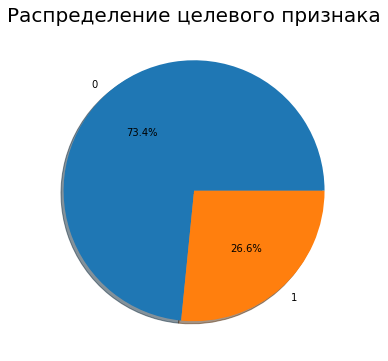

In [48]:
plt.figure(figsize=(20,6))
plt.pie(
    df.groupby('target')['customer_id'].count(), 
    labels=['0','1'], 
    autopct='%.1f%%', 
    shadow=True
    )
plt.title('Распределение целевого признака', fontsize=20)
plt.show()

Больше четверти от общего количества пришедших клиентов. Датасет не сбалансирован, учтем это при обучении модели

Посмотрим как менялся приток и отток клиентов

In [49]:
pivot_begin = df.pivot_table(index=df['begin_date'], values='customer_id', aggfunc='count').reset_index().set_index('begin_date')
pivot_end = df.pivot_table(index=df['end_date'], values='customer_id', aggfunc='count').reset_index().set_index('end_date')

pivot_all = pd.concat([pivot_begin, pivot_end], keys=['In', 'Out'], axis=1).fillna(0)
pivot_all = pivot_all.droplevel(level=1, axis=1)
pivot_all.reset_index()
pivot_all = pivot_all[:-1]

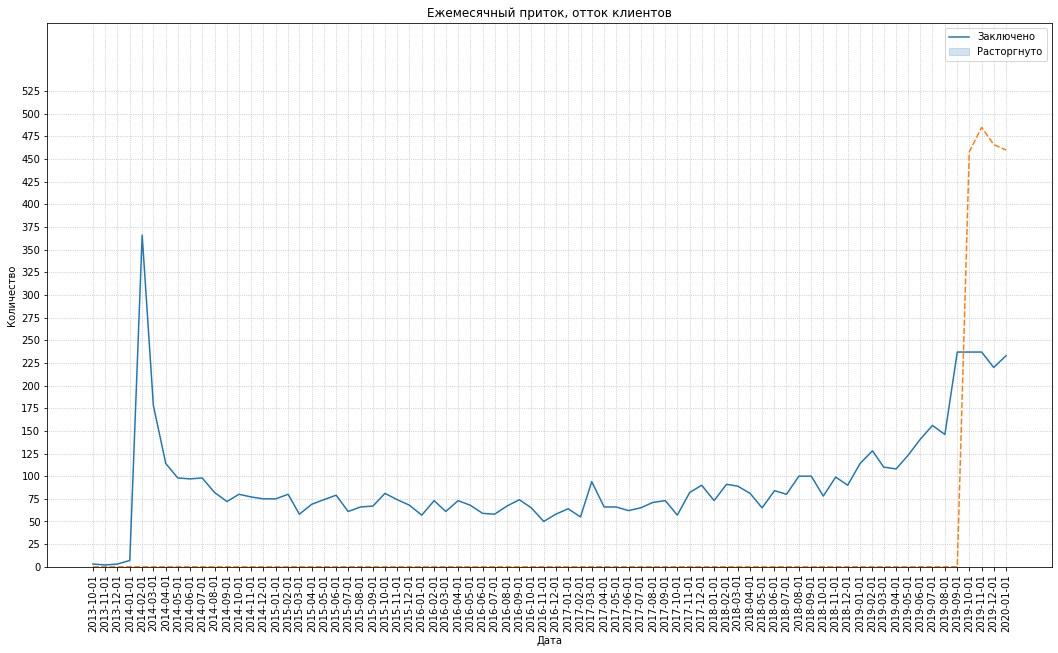

In [50]:
plt.figure(figsize=(18,10))
sns.lineplot(data=pivot_all)
plt.grid(linestyle=':', linewidth=0.7)
plt.xticks(pivot_all.index, rotation=90)
plt

plt.ylim(0, 600)
plt.title('Ежемесячный приток, отток клиентов')
plt.legend(['Заключено', 'Расторгнуто'])
plt.xlabel('Дата')
plt.ylabel('Количество');
plt.yticks(np.arange(0, 550, step=25));

Видим пик числа заклюений в начале 2014 года, далее приток стабилизировался на 50-100 клиентах ежемесячно, до 2019 года.
С начала 2019 наблюдался рост притока до 220 клиентов в месяц где и стабилизировался.

Причем как ранее мы заметили что до октября 2019 года клиенты вообще не расторгали договора(как вариант до октября дата расторжения могла не учитываться, либо клиент просто переставал пользоваться услугами не расторгая договор). А с октября до момента выгрузки стабильный отток составляет более 450 клиентов в месяц. Превышая приток в 2-а раза.

Похоже что увеличение притока числа пользователей совпадает с началом резкого ухода. Проверим уходят ли только недавно пришедшие клиенты.

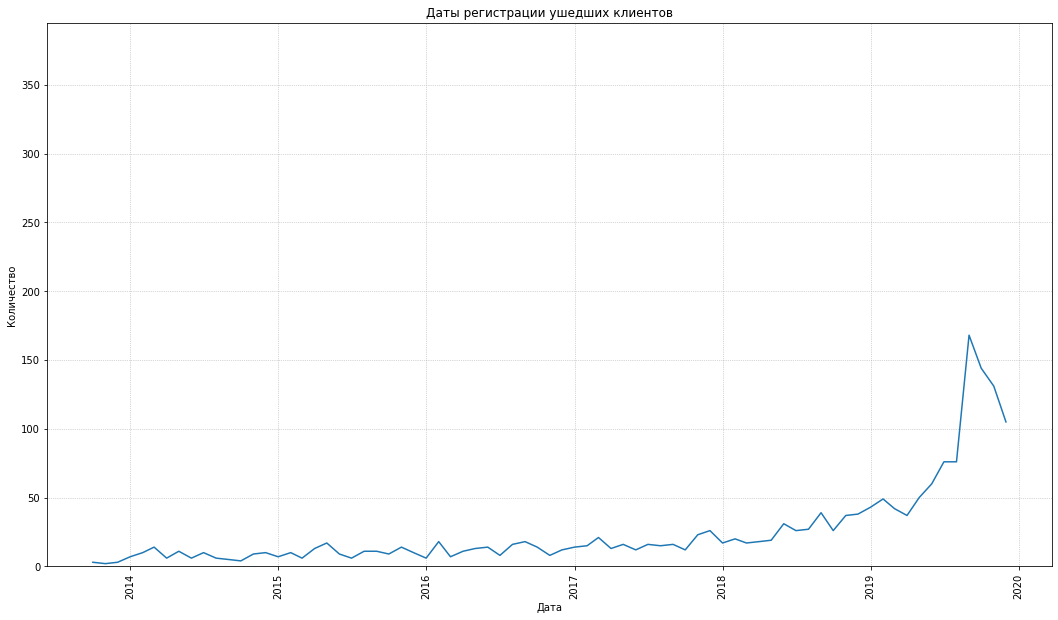

In [51]:
plt.figure(figsize=(18,10))
sns.lineplot(data=df.query('target == 1').groupby('begin_date')['customer_id'].count()) 
plt.grid(linestyle=':', linewidth=0.7)
plt.xticks(rotation=90)

plt.ylim(0, 395)
plt.title('Даты регистрации ушедших клиентов')
plt.xlabel('Дата')
plt.ylabel('Количество');

Максимумы количества уходящих клиентов примерно совпадает с максимумами заключаемых договоров

In [52]:
pip install matplotlib --upgrade

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_455/3317046820.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(


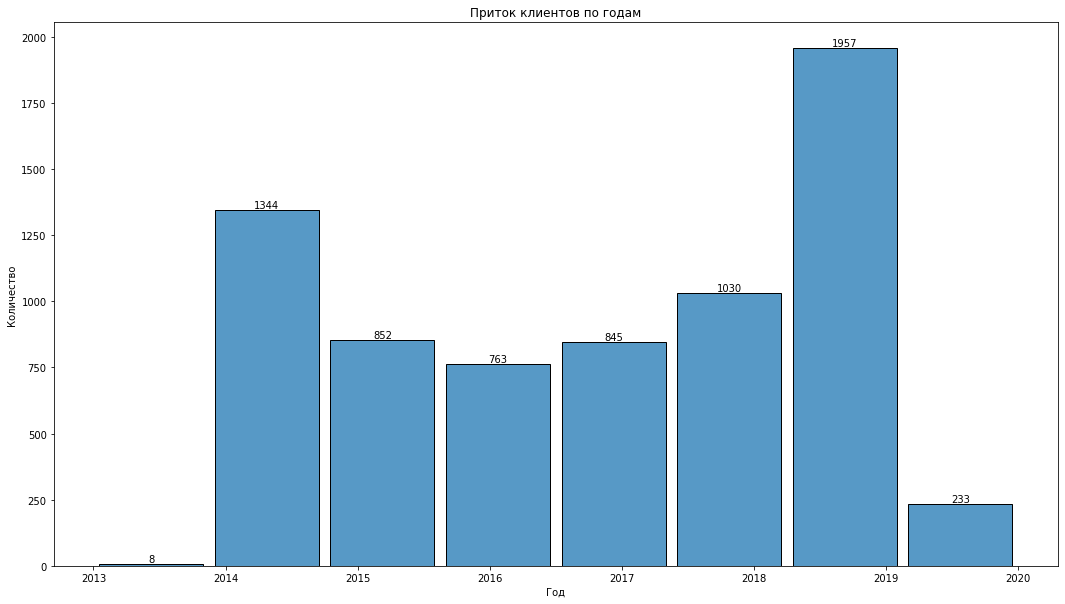

In [53]:
plt.figure(figsize=(18, 10))
ax = sns.histplot(
    data=df, 
    x="start_year",
    multiple="stack", 
    shrink=.9,
    bins=8,
    palette='pastel'
    )
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

plt.title('Приток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество');

Количество заключаемых договоров  с 2016 стабильно растет, особенно в 2019 опередив среднее за 4 предыдущих года. И учитывая темп заключения договоров в 2020 можно предположить что показатели должны быть не хуже чем в 2019 году.


/tmp/ipykernel_455/18724585.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.histplot(


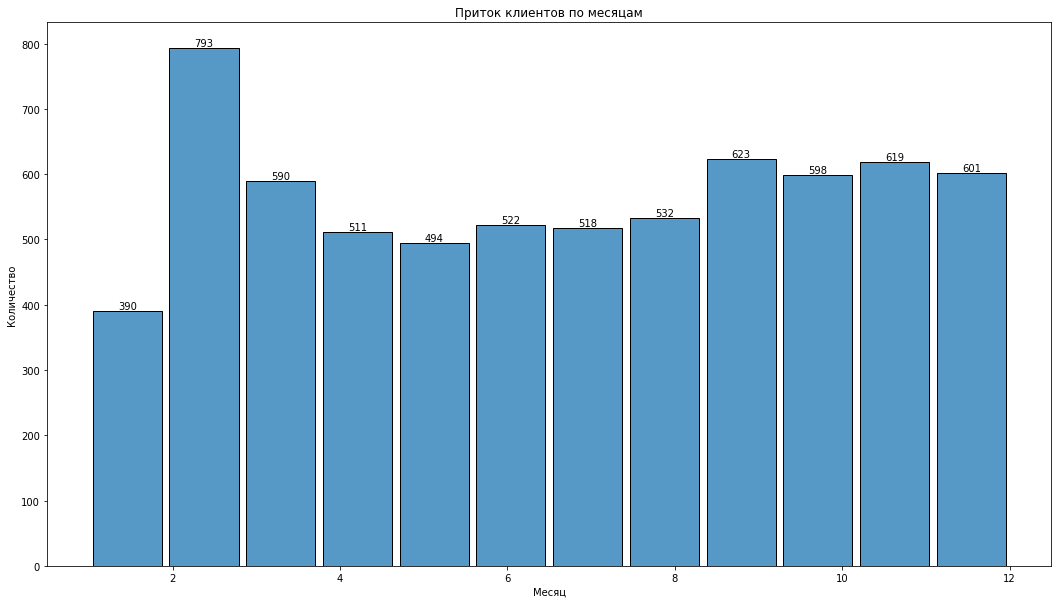

In [54]:
plt.figure(figsize=(18, 10))
ax = sns.histplot(
    data=df.query('start_year not in [2013, 2020]'), 
    x="start_month",
    multiple="stack", 
    shrink=.9,
    bins=12,
    palette='pastel'
    )
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

plt.title('Приток клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество');

Больше всего договоров было заключено в феврале, начиная с мая и в летние месяцы спад, и с сентября количество договоров снова растет 

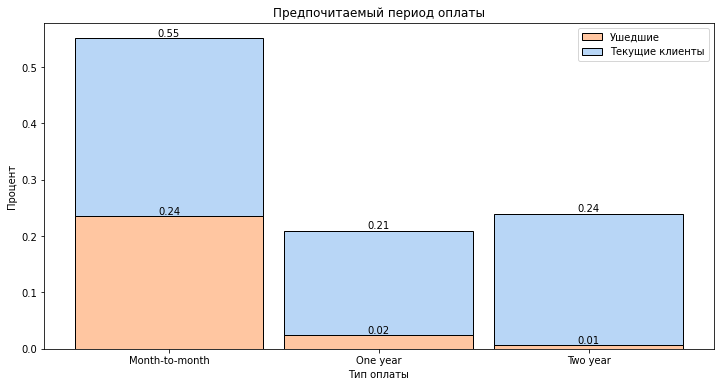

In [55]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df, 
    x="type", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel'
    )
for c in ax.containers:
    ax.bar_label(c, fmt='%0.2f', label_type='edge')
plt.legend(['Ушедшие', 'Текущие клиенты', ])
plt.title('Предпочитаемый период оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Процент');

Большая часть ушедших клиентов оплачивали услуги ежемесячно, реже всего уходят те кто платит на два года вперед

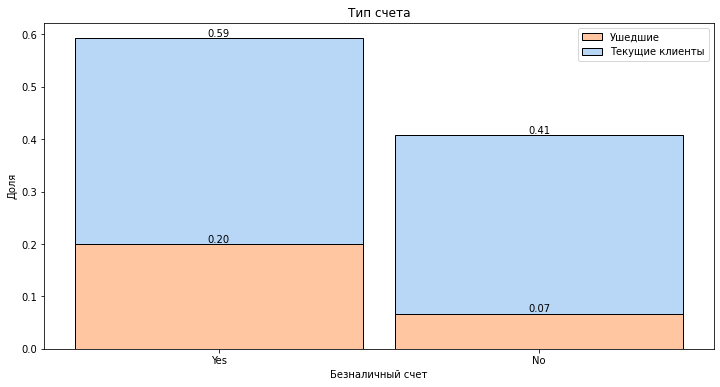

In [56]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df, 
    x="paperless_billing", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel'
    )
for c in ax.containers:
    ax.bar_label(c, fmt='%0.2f', label_type='edge')
plt.legend(['Ушедшие', 'Текущие клиенты', ])
plt.title('Тип счета')
plt.xlabel('Безналичный счет')
plt.ylabel('Доля');

Большая часть предпочитает безналичный способ оплаты, и процент ушедших среди них выше

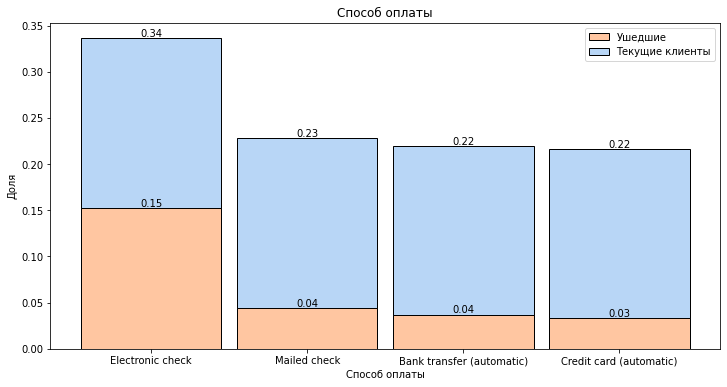

In [57]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df, 
    x="payment_method", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel'
    )
for c in ax.containers:
    ax.bar_label(c, fmt='%0.2f', label_type='edge')
plt.legend(['Ушедшие', 'Текущие клиенты'])
plt.title('Способ оплаты')
plt.xlabel('Способ оплаты')
plt.ylabel('Доля');

Треть пользователей платит электронным чеком, из них половина уходит. Остальные способы оплаты вместе с долей ушедших распределены примено равными долями

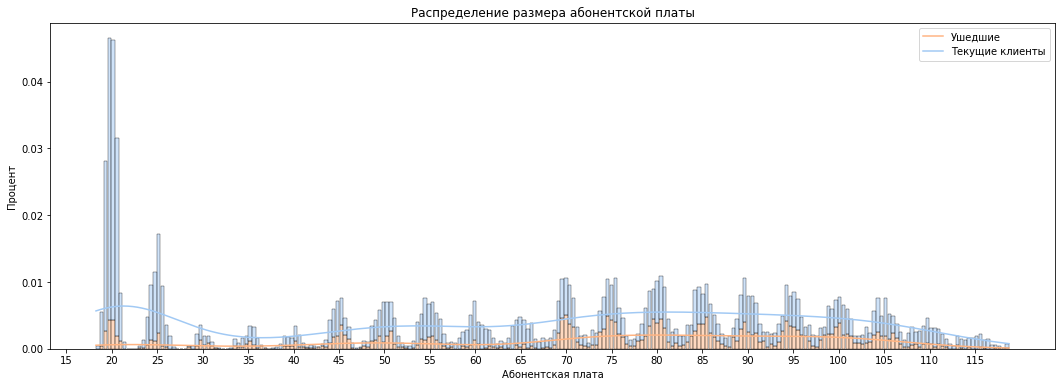

In [58]:
plt.figure(figsize=(18, 6))
sns.histplot(
    data=df, 
    x="monthly_charges", 
    hue="target",
    bins=240, 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel',
    kde=True
    )
plt.xticks(np.arange(15, 120, step=5))
plt.legend(['Ушедшие', 'Текущие клиенты', ])
plt.title('Распределение размера абонентской платы')
plt.xlabel('Абонентская плата')
plt.ylabel('Процент');

Размер абонентской платы групируются вокруг значений кратных 5.

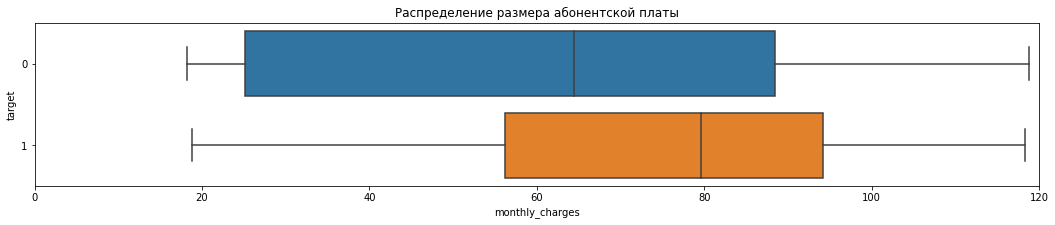

In [59]:
plt.figure(figsize=(18,3))
plt.title('Распределение размера абонентской платы')
sns.boxplot(x = "monthly_charges", y = "target", data=df, orient='h')
plt.xlim(0, 120);

У ушедших клиентов стоимость абонентской платы была в среднем выше и распределена более узким диапазоном от 55 до 90 с медианой около 80, в отличии от оставшихся клиентов у которых наиболее частые значения распределены от 25 до 90 с медианой около 65. У ушедших клиентов была более высокая абонентская плата

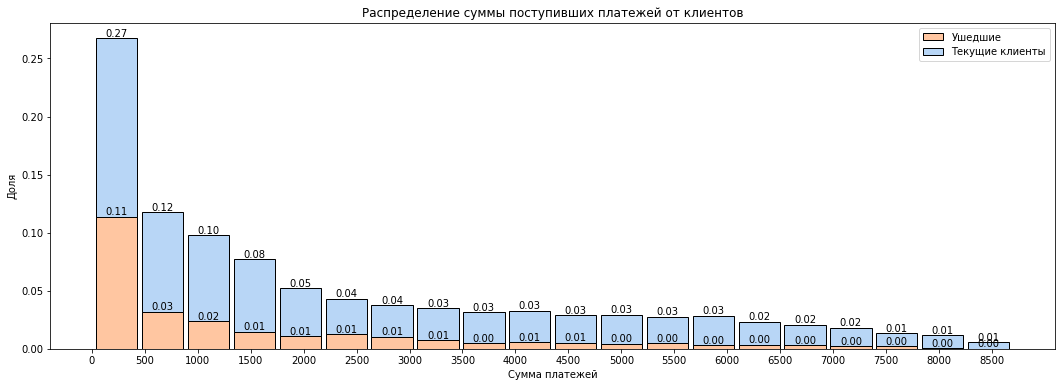

In [60]:
plt.figure(figsize=(18, 6))
ax = sns.histplot(
    data=df, 
    x="total_charges", 
    hue="target",
    bins=20, 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel'
    )

for c in ax.containers:
    ax.bar_label(c, fmt='%0.2f', label_type='edge')

plt.xticks(np.arange(0, 9000, step=500))
plt.legend(['Ушедшие', 'Текущие клиенты', ])
plt.title('Распределение суммы поступивших платежей от клиентов')
plt.xlabel('Сумма платежей')
plt.ylabel('Доля');

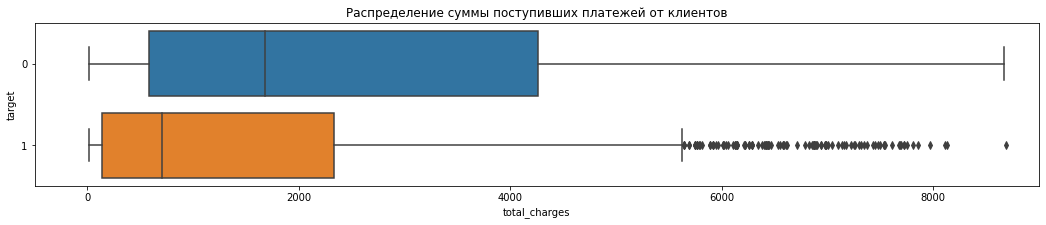

In [61]:
plt.figure(figsize=(18,3))
plt.title('Распределение суммы поступивших платежей от клиентов')
sns.boxplot(x = "total_charges", y = "target", data=df, orient='h')
plt.xlim(-500, 9000);

Не смотря на более высокую абонентскую плату распределение противоположно размеру абонентской платы - общая сумма поступивших платежей больше у оставшихся клиентов.

Посмотрим на портрет клиент ушедших и оставшихся клиентов

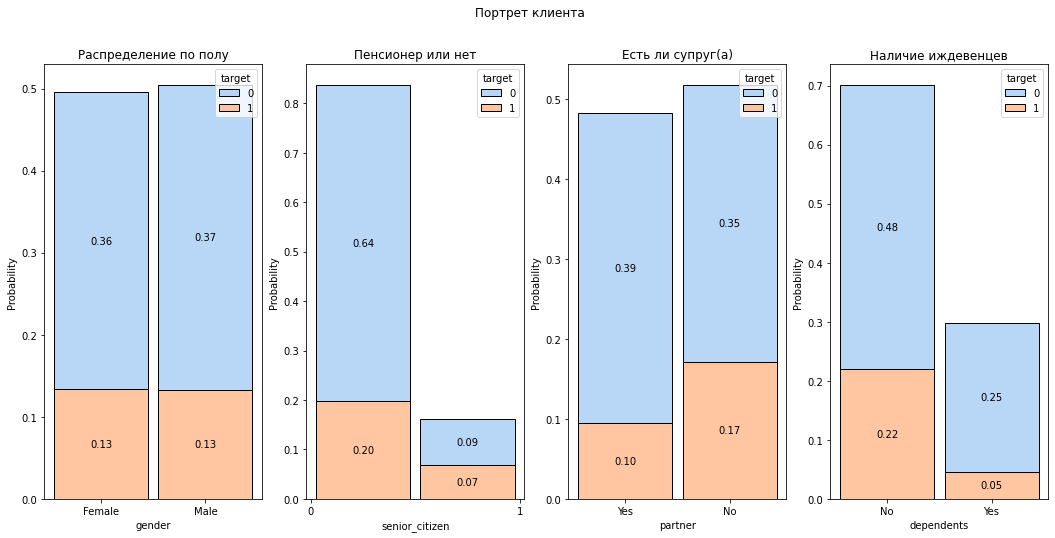

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(18,8))

ax1 = sns.histplot(
    data=df, 
    x="gender", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel',
    ax = axes[0])

ax2 = sns.histplot(
    data=df, 
    x="senior_citizen",
    bins=2, 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel',
    ax = axes[1])

ax3 = sns.histplot(
    data=df, 
    x="partner", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel',
    ax = axes[2])

ax4 = sns.histplot(
    data=df, 
    x="dependents", 
    hue="target", 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel',
    ax = axes[3])

axes[0].set_title("Распределение по полу")
axes[1].set_title("Пенсионер или нет")
axes[2].set_title("Есть ли супруг(а)")
axes[3].set_title("Наличие иждевенцев")
axes[1].set_xticks(np.arange(0, 2, step=1))

axs = [ax1, ax2, ax3, ax4]

for ax in axs:
    for c in ax.containers:
        ax.bar_label(c, fmt='%0.2f', label_type='center')

plt.suptitle("Портрет клиента")
plt.show()

По полу клиенты распределены практически одинаково, причем и доля ушедших тоже. 
Следовательно данный признак можно будет не использовать для обучения
Пенсионеров в выборке меньше но доля ушедших среди них около 40%
Клиентов не сосоящие в отношениях не значительно больше, а доля ушедших среди них выше.
Клиентов без иждевенцев 70% и доля ушедших среди них чуть выше

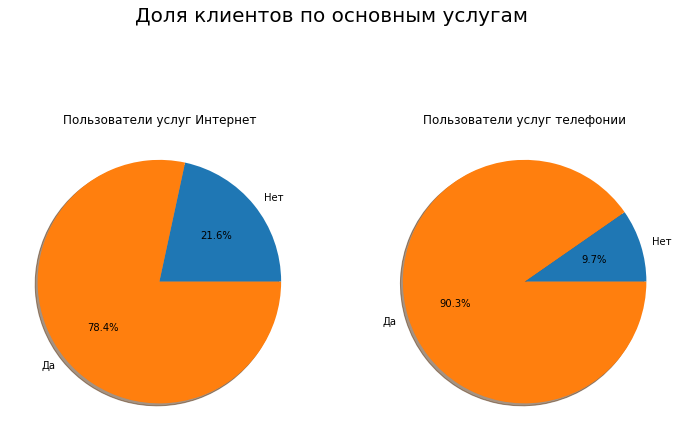

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
fig.suptitle('Доля клиентов по основным услугам', fontsize=20)
ax1.pie(
    df.groupby('internet_service')['internet_service'].count(), 
    labels=['Нет','Да'], 
    autopct='%.1f%%', 
    shadow=True,
    )
ax1.set_title('Пользователи услуг Интернет')

ax2.pie(
    df.groupby('phone_service')['phone_service'].count(), 
    labels=['Нет','Да'], 
    autopct='%.1f%%', 
    shadow=True
    )
ax2.set_title('Пользователи услуг телефонии')
plt.show();

Доля клиентов с услугой телефонии выше чем услуги Интернет

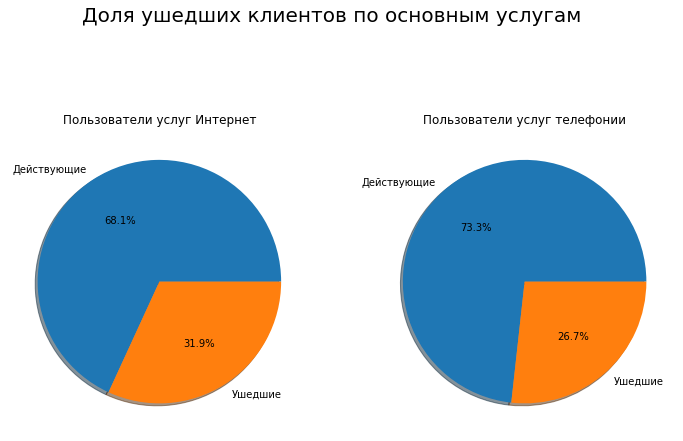

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
fig.suptitle('Доля ушедших клиентов по основным услугам', fontsize=20)
ax1.pie(
    df.query('internet_service == "Yes"').groupby('target')['internet_service'].count(), 
    labels=['Действующие', 'Ушедшие'],
    autopct='%.1f%%', 
    shadow=True,
    )
ax1.set_title('Пользователи услуг Интернет')

ax2.pie(
    df.query('phone_service == "Yes"').groupby('target')['phone_service'].count(), 
    labels=['Действующие', 'Ушедшие'],
    autopct='%.1f%%', 
    shadow=True
    )
ax2.set_title('Пользователи услуг телефонии')
plt.show();

Доля ушедших клиентов в разрезе по услугам примерно одинаковы

Посмотрим какими услугами пользовались ушедшие и оставшиеся клиенты

In [65]:
sum_services = pd.DataFrame(df[['online_security', 'online_backup', 
                                'device_protection', 'tech_support', 
                                'streaming_tv', 'streaming_movies', 
                                'multiple_lines']].replace({'Yes':1, 'No':0}).sum()).reset_index()
sum_services.columns = ['name', 'sum']

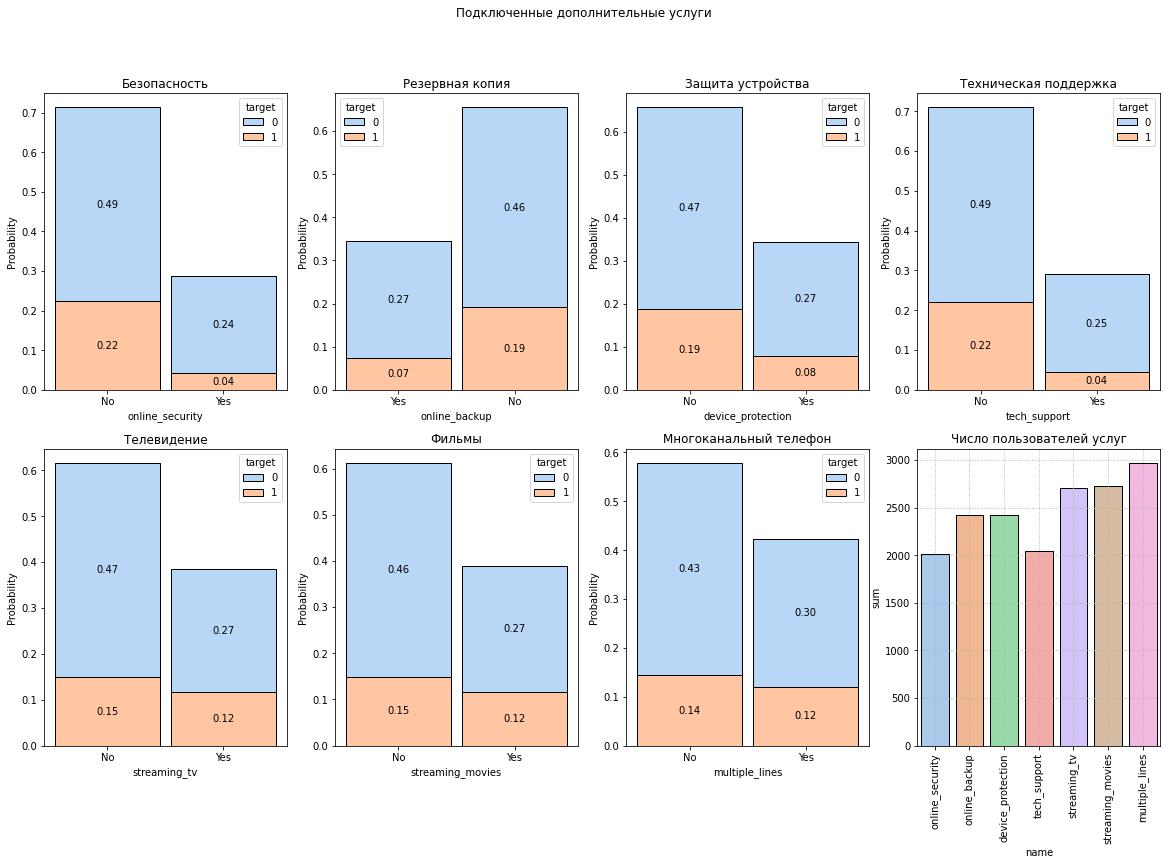

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(20,12))

ax1 = sns.histplot(data=df, x="online_security", hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[0, 0])

ax2 = sns.histplot(data=df, x="online_backup", bins=2, hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[0, 1])

ax3 = sns.histplot(data=df, x="device_protection", hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[0, 2])

ax4 = sns.histplot(data=df, x="tech_support", hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[0, 3])

ax5 = sns.histplot(data=df, x="streaming_tv", hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[1, 0])

ax6 = sns.histplot(data=df, x="streaming_movies", bins=2, hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[1, 1])

ax7 = sns.histplot(data=df, x="multiple_lines", hue="target", multiple="stack", shrink=.9,
    stat='probability', palette='pastel', ax = axes[1, 2])

ax8 = sns.barplot(data=sum_services, x='name', y='sum', palette='pastel', edgecolor = "black",
    ax = axes[1, 3])

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
axes[0, 0].set_title("Безопасность")
axes[0, 1].set_title("Резервная копия")
axes[0, 2].set_title("Защита устройства")
axes[0, 3].set_title("Техническая поддержка")
axes[1, 0].set_title("Телевидение")
axes[1, 1].set_title("Фильмы")
axes[1, 2].set_title("Многоканальный телефон")
axes[1, 3].set_title("Число пользователей услуг")
axes[1, 3].grid(linestyle=':', linewidth=0.9)

plt.xticks(rotation=90)         
plt.suptitle("Подключенные дополнительные услуги")
for ax in axs:
    for c in ax.containers:
        ax.bar_label(c, fmt='%0.2f', label_type='center')

plt.show()

Безопасность и услуга технической поддержки: около 30% пользуются услугой доля ушедших выше среди тех кто не пользуются данной услугой ~1/3 против 1/5 для тех кто пользуется

Услугой резервной копии и защитой устройства: 35% пользуются услугами из них 1/3 ушли, из тех кто не использует данные услуги незначительно меньше

Онлайн телевидением и фильмами пользуются около 30% из них также примерно 1/3 ушла также как и среди оставшихся

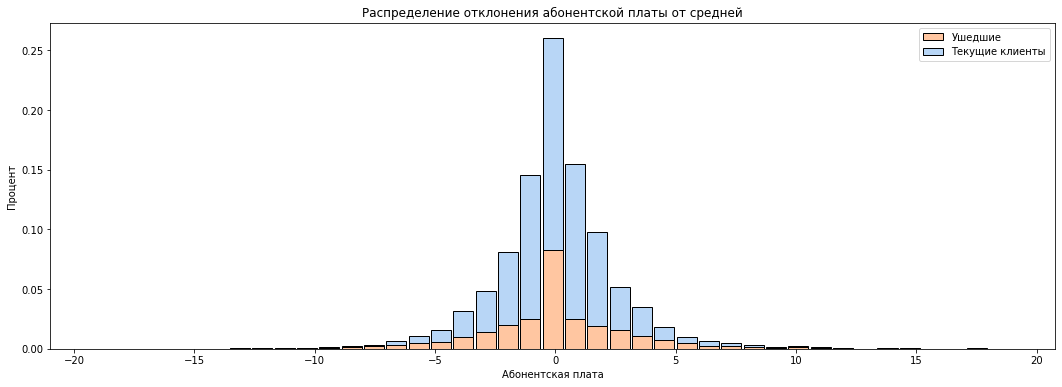

In [67]:
plt.figure(figsize=(18, 6))
sns.histplot(
    data=df, 
    x="reduce_increase_services", 
    hue="target",
    bins=41, 
    multiple="stack", 
    shrink=.9,
    stat='probability',
    palette='pastel'
    )

plt.legend(['Ушедшие', 'Текущие клиенты'])
plt.title('Распределение отклонения абонентской платы от средней')
plt.xlabel('Абонентская плата')
plt.ylabel('Процент');

Распреление симметричное доля ушедших также никак не выделяется

Проверим текстовую часть ID

In [68]:
df['text_id'] = df['text_id'].apply(lambda x: ' '.join(x))

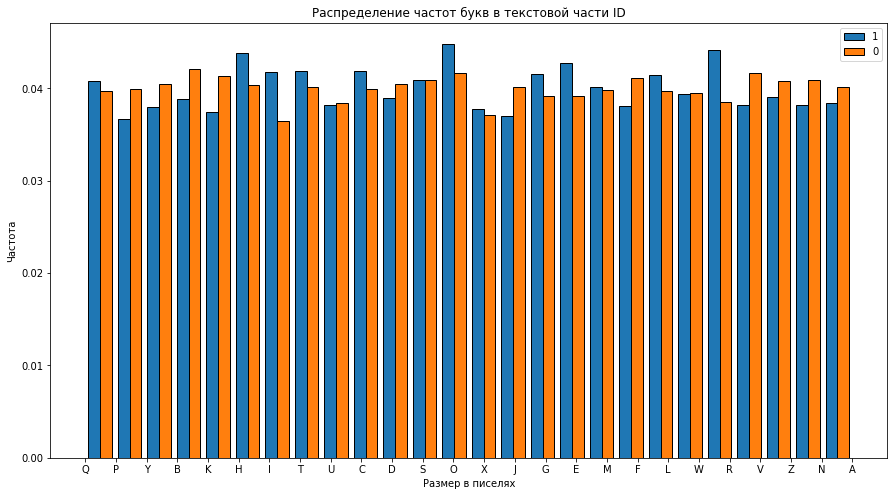

In [69]:
plt.figure(figsize=(15,8))
plt.hist([df.query('target == 1').text_id.str.split(expand=True).stack(), 
          df.query('target == 0').text_id.str.split(expand=True).stack()], 
          bins=(df.query('target == 0').text_id.str.split(expand=True).stack().nunique()), edgecolor = "black", density=True)
plt.title('Распределение частот букв в текстовой части ID')
plt.legend(['1', '0'])
plt.xlabel('Размер в писелях')
plt.ylabel('Частота')
#plt.xlim(0, 30);
plt.show()

In [70]:
char_freq_target = df.query('target == 1').text_id.str.split(expand=True).stack().value_counts(normalize=True)#.sort_values()
char_freq_not_target = df.query('target == 0').text_id.str.split(expand=True).stack().value_counts(normalize=True)#

In [71]:
chars = pd.DataFrame(char_freq_target)
chars = chars.merge(pd.DataFrame(char_freq_not_target), left_index=True, right_index=True)
chars['diff'] = abs(chars['0_x'] - chars['0_y'])
chars = chars.sort_values('diff', ascending=False)

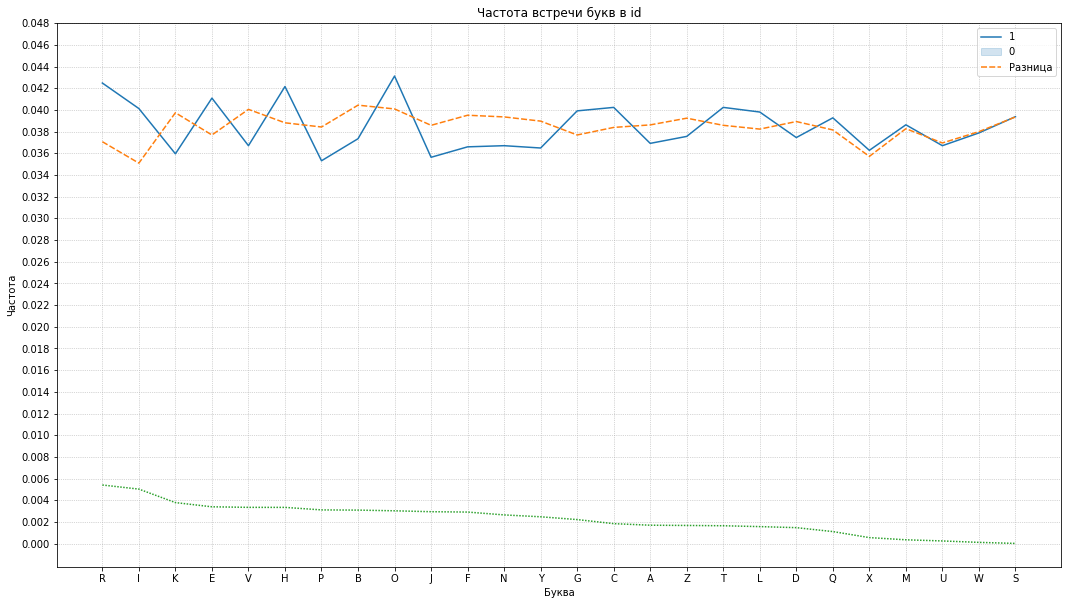

In [72]:
plt.figure(figsize=(18,10))
sns.lineplot(data=chars)
plt.grid(linestyle=':', linewidth=0.7)

plt.title('Частота встречи букв в id')
plt.legend(['1', '0', 'Разница'])
plt.xlabel('Буква')
plt.ylabel('Частота')
plt.yticks(np.arange(0, 0.05, step=0.002));

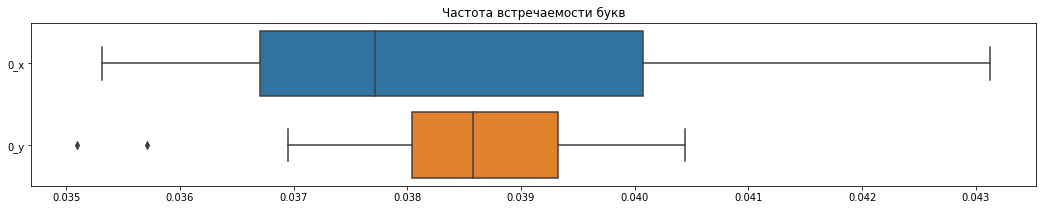

In [73]:
plt.figure(figsize=(18,3))
plt.title('Частота встречаемости букв')
sns.boxplot(data=chars[['0_x', '0_y']], orient='h');

Есть два выброса, но в целом одно распределение перекрывает другое

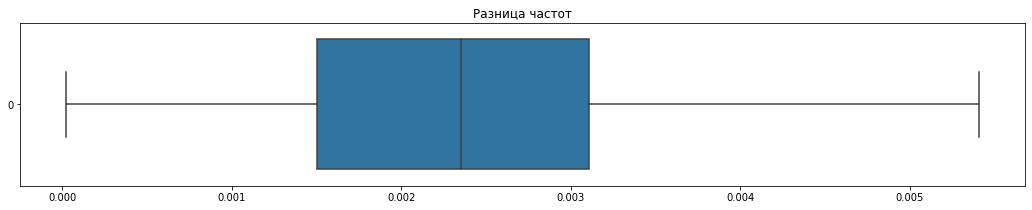

In [74]:
plt.figure(figsize=(18,3))
plt.title('Разница частот')
sns.boxplot(data=chars['diff'], orient='h');

Если бы на данной диаграмме были бы обнаружены выбросы в большую сторону тогда можно было бы сформировать столбец с наличием/отсутствием буквы в `text_ID`

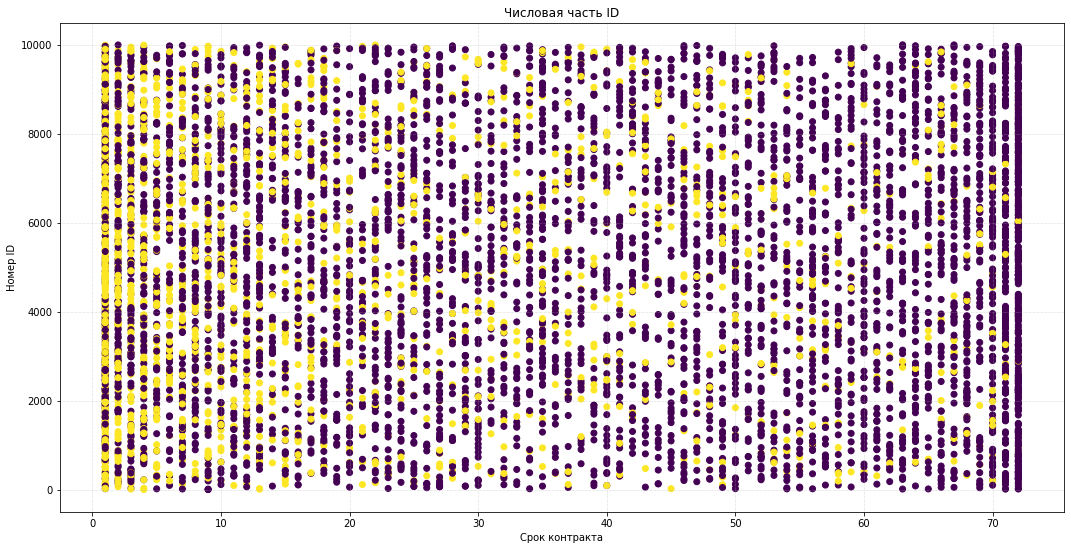

In [75]:
plt.figure(figsize=(18, 9))
plt.scatter( 
    df['term'],
    df['num_id'],
    c=df['target']
    )
plt.grid(linestyle=':', linewidth=0.5)
plt.title('Числовая часть ID')
plt.xlabel('Срок контракта')
plt.ylabel('Номер ID');

Числовая часть также не представляет ничего интересного, данные распределены равномерно по номерам.

Удалим столбцы с лишней информацией по результатам исследования, остальные проверим на корреляциию phik

In [76]:
df = df.drop(['begin_date', 'end_date', 
              'customer_id', 'num_id', 
              'text_id', 'start_month', 
              'start_year'], axis=1)

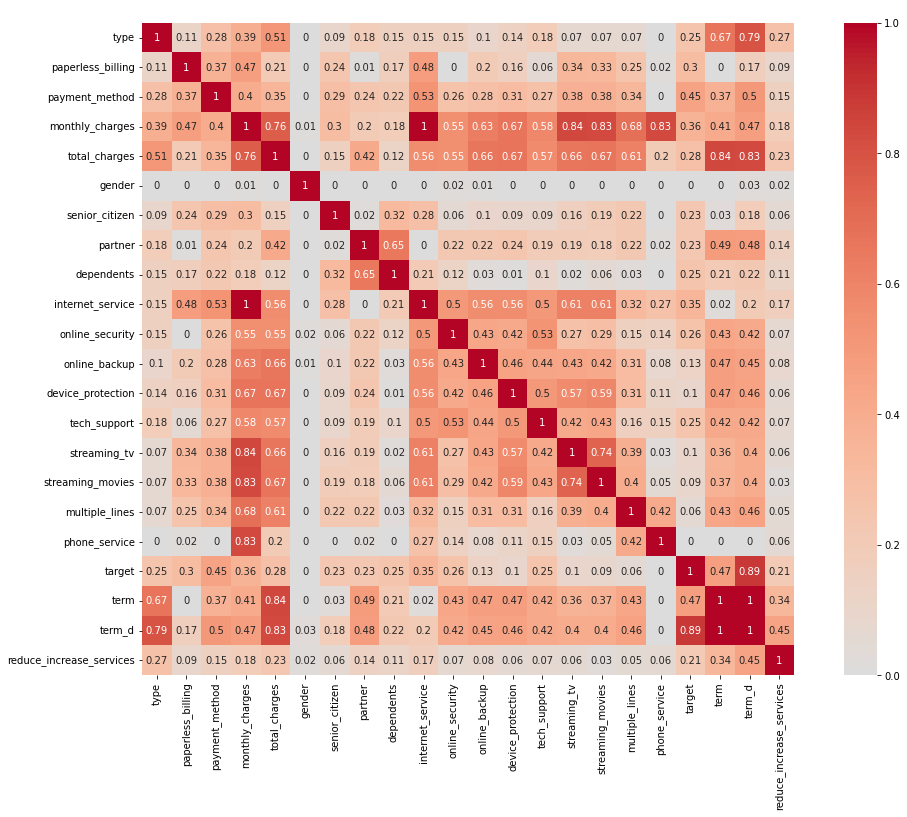

In [77]:
interval  = ['monthly_charges', 'total_charges',  'term', 'reduce_increase_services']
phik_overview = df.phik_matrix(interval_cols=interval)
plt.figure(figsize=(18, 12))
plt.title(' ')
sns.heatmap(round(phik_overview, 2), 
            annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

'gender' - как и ожидалось нулевая зависимость между всеми переменными

In [78]:
corr_feat = set()
corr_matrix = phik_overview
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{'internet_service', 'term_d'}

Столбцы с мультиколлинерностью удалим

In [79]:
dfs = df.copy()

Проверим гипотезу о том что чаще уходят новые клиенты
Н0 - клиенты уходят в независимости от длительности срока контракта
Н1 - срок контракта имеет значение

In [80]:
alpha = 0.05

results = st.ttest_ind(df.query('target == 1')['term'], 
                       df.query('target == 0')['term'], 
                       equal_var = False)

print(results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.3470747188949523e-234
Отвергаем нулевую гипотезу


Зависимость между фактом ухода и сроком контракта подтверждается

## Подготовка и обучение модели

Делим на обучающую и тестовую выборки

In [81]:
X, y = dfs.drop(['target', 'term'], axis=1), dfs['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=dfs['target']
    )

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (5274, 20)
Доля целевого признака: 0.266
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (1758, 20)
Доля целевого признака: 0.266
------------------------------


Переменные разобьем на две категории. В числовые попал признак пенсионер или нет, так там 1-0 на обучение повлиять не должно

In [82]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Категориальные признаки: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'phone_service']
Числовые признаки: ['monthly_charges', 'total_charges', 'senior_citizen', 'term_d', 'reduce_increase_services']


Создадим pipeline с 4 моделями построенных на разных принципах

In [83]:
cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])
num_pipe = Pipeline([('scaler', RobustScaler())])

preprocessor = ColumnTransformer(
     [
         ('cat', cat_pipe, categorical),
         ('num', num_pipe, numerical), #0.888529
     ], remainder ='passthrough') 

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("regressor", LogisticRegression())
    ]
)

param_grid = [
     {
         'regressor': [KNeighborsClassifier()],
         'regressor__n_neighbors': range(2,40,2),
         'regressor__weights': ['uniform', 'distance'],
         'regressor__algorithm': ['auto', 'brute'] #, 
     },
     {
         'regressor': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
         'regressor__C': [0.01, 0.1, 1, 5, 10, 30],
         'regressor__solver': ['saga', 'liblinear'],
         'regressor__max_iter':[2000, 8000],
         'regressor__fit_intercept': [True, False]
     },
     {
         'regressor': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True, early_stopping_rounds=10)],
         'regressor__iterations': range(50, 400, 50),
         'regressor__depth' : range(1, 8, 1),
         'regressor__l2_leaf_reg': range(1, 13, 1),
         'regressor__learning_rate': np.linspace(0.01, 0.5, 15),
         'regressor__auto_class_weights': ['Balanced', 'SqrtBalanced']
     },
     {
         'regressor': [MLPClassifier(random_state=RANDOM_STATE, early_stopping=True)],
         'regressor__hidden_layer_sizes': [(50,50),(100,100)], 
         'regressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
         'regressor__learning_rate_init': [0.1, 0.01]

     }    
]


grid = RandomizedSearchCV(pipe, param_grid, n_iter=30 ,cv=5, scoring = 'roc_auc', verbose=3, random_state=RANDOM_STATE)

Модель готова к обучению

In [84]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END regressor=<catboost.core.CatBoostClassifier object at 0x7f130e95e5b0>, regressor__auto_class_weights=SqrtBalanced, regressor__depth=5, regressor__iterations=50, regressor__l2_leaf_reg=9, regressor__learning_rate=0.21999999999999997; total time=   0.6s
[CV 2/5] END regressor=<catboost.core.CatBoostClassifier object at 0x7f130e95e5b0>, regressor__auto_class_weights=SqrtBalanced, regressor__depth=5, regressor__iterations=50, regressor__l2_leaf_reg=9, regressor__learning_rate=0.21999999999999997; total time=   0.5s
[CV 3/5] END regressor=<catboost.core.CatBoostClassifier object at 0x7f130e95e5b0>, regressor__auto_class_weights=SqrtBalanced, regressor__depth=5, regressor__iterations=50, regressor__l2_leaf_reg=9, regressor__learning_rate=0.21999999999999997; total time=   0.5s
[CV 4/5] END regressor=<catboost.core.CatBoostClassifier object at 0x7f130e95e5b0>, regressor__auto_class_weights=SqrtBalanced, regressor__dept

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'gender',
                                                                                'partner',
                        

Результаты лучших 5 моделей

In [85]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__l2_leaf_reg,param_regressor__iterations,param_regressor__depth,param_regressor__auto_class_weights,param_regressor,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.895406,0.068325,0.017726,0.000794,0.36,12,350,2,SqrtBalanced,<catboost.core.CatBoostClassifier object at 0x...,"{'regressor__learning_rate': 0.36, 'regressor_...",0.913624,0.894933,0.908809,0.893137,0.904072,0.902915,0.007875,1
15,1.222508,0.022651,0.018094,0.000609,0.22,5,350,5,SqrtBalanced,<catboost.core.CatBoostClassifier object at 0x...,{'regressor__learning_rate': 0.219999999999999...,0.896230,0.898385,0.895266,0.889477,0.897571,0.895386,0.003143,2
29,0.696216,0.032323,0.017143,0.000403,0.465,7,150,4,SqrtBalanced,<catboost.core.CatBoostClassifier object at 0x...,{'regressor__learning_rate': 0.464999999999999...,0.902055,0.894836,0.895478,0.887914,0.894396,0.894936,0.004485,3
28,0.780350,0.027926,0.017827,0.000747,0.43,12,200,4,Balanced,<catboost.core.CatBoostClassifier object at 0x...,{'regressor__learning_rate': 0.429999999999999...,0.906472,0.889062,0.888546,0.890038,0.887170,0.892258,0.007167,4
23,1.689193,0.223815,0.019197,0.000630,0.115,4,350,6,Balanced,<catboost.core.CatBoostClassifier object at 0x...,{'regressor__learning_rate': 0.114999999999999...,0.892175,0.893122,0.891666,0.889546,0.885174,0.890337,0.002835,5


Проверим результаты на тестовой выборке

In [86]:
pred = grid.best_estimator_.predict_proba(X_test)[:,1]
best_auc = roc_auc_score(y_test, pred)
if best_auc > 0.85:
    print(f'Условие задачи выполнены, F1 на тестовой выборке составил: {best_auc:0.4f}')
else:
    print(f'Необходимо еще оптимизировать параметры, F1 на тестовой выборке всего лишь: {best_auc:0.4f}')

Условие задачи выполнены, F1 на тестовой выборке составил: 0.9174


Нарисуем ROC-AUC кривую

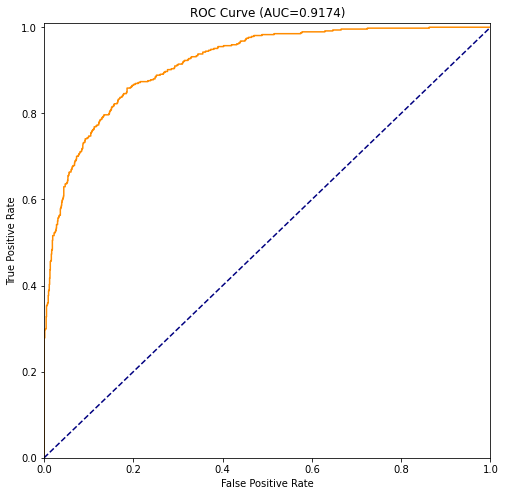

In [87]:
predicted_valid = grid.best_estimator_.predict_proba(X_test)[:, 1] #grid.best_estimator_.predict(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_valid)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})')
plt.show()

Посмотрим матрицу распределения ошибок

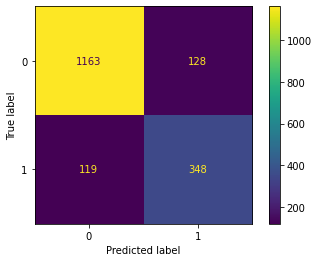

Accuracy на тестовой выборке составляет 0.8594994311717861


In [88]:
predicted_valid = np.where(predicted_valid > 0.5, 1, 0)
conf_mx = confusion_matrix(y_test, predicted_valid)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mx)
cm_display.plot()
accuracy = accuracy_score(y_test, predicted_valid)
plt.show()
print(f'Accuracy на тестовой выборке составляет {accuracy}')

На тестовой выборке модель пропускает как клиентов ушедших так и клиентов не собиравшихся уходить примерно в равных долях, но в целом показатель не плохой

In [89]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dum_pred = dummy_clf.predict(X_test)
dummy_score = roc_auc_score(y_test, dum_pred)

if best_auc > dummy_score:
    print(f'Метрика AUC выше у модели на: {best_auc - dummy_score:0.4f}')
else:
    print(f'Метрика AUC выше у Dummy на: {dummy_score - best_auc:0.4f}, необходимо проверить параметры')

Метрика AUC выше у модели на: 0.4174


Результат превосходит dummy модель

Для оценки важности параметров воспользуемся feature_importances, а для того чтобы извлечь их из результата работы ColumnTransformer следующим решением:

In [90]:
def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=False, verbose=True):  

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
    
    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_): 
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose: 
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer,'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer,'features_'):
            # is this a MissingIndicator class? 
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose: 
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    
    return new_feature_names

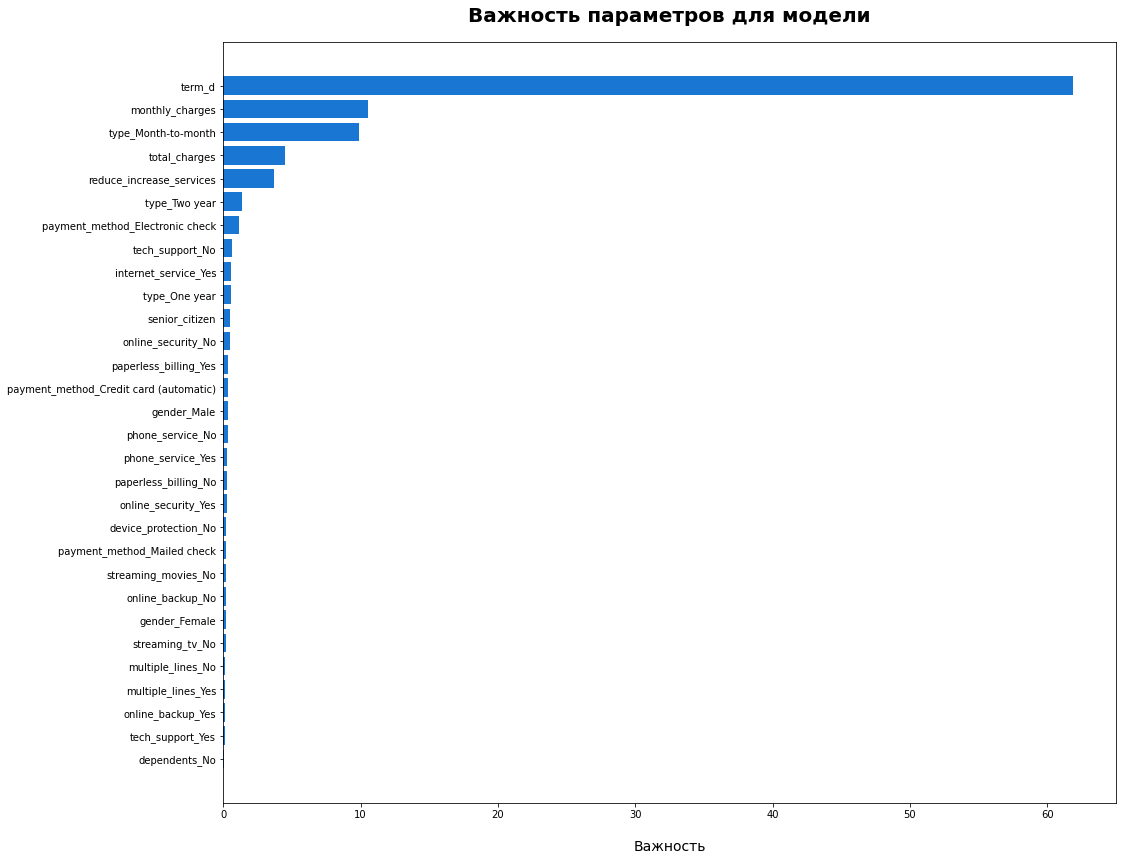

In [91]:
dset = pd.DataFrame()
dset['attr'] = get_column_names_from_ColumnTransformer(grid.best_estimator_.named_steps['preprocessor'], verbose=False)
dset['importance'] = grid.best_estimator_.named_steps["regressor"].feature_importances_

dset = dset.sort_values(by='importance').tail(30)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Важность параметров для модели', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Важность', fontsize=14, labelpad=20)
plt.show()

Первые 4 наиболее важных для модели признака срок контракта, ежемесячная стоимость, отклонение от средней ежемесячной стоимости, и всего поступлений платежей

Параметры финальной модели

In [92]:
grid.best_estimator_.named_steps["regressor"].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 350,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 12,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 10,
 'class_names': [0, 1],
 'random_seed': 270223,
 'depth': 2,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [1, 1.661857008934021],
 'classes_count': 0,
 'auto_class_weights': 'SqrtBalanced',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate':

# Отчет

В данной работе нами проведено исследование данных клиентов телеком компании. Изучили влияние различных факторов и построили модель прогноза вероятности оттока. Работа проведена без отклонений от первоначального плана, все этапы выполнены и важны для получения текущего результата. Основные затруднения возникли из-за утечки при использовании производного признака от даты начала контракта.

На этапе загрузки и ознакомления загрузили 4 файла с данными в формате `*.csv`. Данные разделены на информацию о контракте, услугах Интернет, услугах телефона и персональной информации о клиенте. Определили что пропуски отсутствуют

`contract` Данные предоставлены с 2014-02-01 по 2020-02-01. 7043 строки  по 8 признаков. Пропуски и дубликаты не найдены. Обнаружены несоответствия типов данных. Из двух столбцов даты начала контракта и его окончания необходимо будет сформировать длительность пользования услугами, и выделить целевую переменную - факт окончания контракта.

`internet` 5517 клиентов с 8-ю признаками. Преобразования не требуются.

`personal` 7043 строки с 5-ю признаками. Признак `senior_citizen` кодирован 1/0 вместо обычного yes/no

`phone` 6361 строка с 2-я признаками

Так как не все пользователи пользуются услугами Интернет или телефонии, образовались пропуски которые мы заполнили типичным для для данного датасета значением Yes/No. В столбце с датой окончания контракта для действующих клиентов проставлено значение `No` заменили его на дату выгрузки данных 2020-02-01 и преобразовали в формат даты. Сформировали целевую переменную target - факт ухода клиента.

Так как если бы оставили дату начала договора получили бы утечку данных, выделим новый признак срок контракта в днях. 

В столбце с суммой поступивших платежей обнаружили пропуски заполненные пробелом для пользователей пришедших в текущем месяце. Так как таких пользователей всего 11 удалили их. Для проверки на возможные зависимости разложили на текстовую и числовую часть для проверки на возможные зависимости. Добавили столбец с разницей между текущим ежемесячным платежом и средним за весь период контракта.

На этапе исследовательского анализа данных обнаружили дисбаланс классов для целевой переменной. Данных о расторжении договоров ранее 2019-10-01 нет, возможная причина отсутствие учета таких клиентов и они отфильтрованы из таблицы (так как столбец с ежемесячным платежом у нас без нулевых значений и пропусков). Пик даты регистраций уходящих клиентов приходится на пик притока новых клиентов в конце 2019 года.
Даже с учетом возрастания числа уходящих клиентов, в 2019 год приток клиентов продолжил рост с 2016 года и учитывая не полные данные за 2020 год тенденция должна сохраниться.

Сезонность притока клиентов по месяцам в течении года ожидаемо минимальна в январе далее высокие показатели до апреля-мая до сентября некоторый спад и с сентября по декабрь стабильно высокие. Минимум января и пик февраля выбиваются из общего ряда. Январь месяц новогодних праздников а пик февраля совпал с большим притоком 2014.

По предпочтительному способу оплаты самыми надежными клиентами являются клиенты с ежегодным и двухлетним планом оплаты. Самыми не надежными - клиенты с ежемесячной оплатой доля оттока среди них достигает 42%. 

Безналичным типом счета пользуются 60% пользователей, с долей оттока 30%. При оплате наличными отток составляет 16%.

Среди способов оплаты наиболее популярный электронный им пользуются 30%  при этом имеет самый большой отток близкий к 50%. Остальными способами: почтовым чеком, и двумя автоматическими способами: банковским переводам и оплатой картой пользуются примерно равными долями по 21-23% пользователей. Доля оттока у последних трех способов также не сильно отличается от 3,3 до 4,4%%.

Ежемесячная абонентская плата распределена от 18,25 до 118,75 ежемесячно. Значения распределены не равномерно на всем диапазоне, концентрируясь "вокруг" значений кратных 5. Группы значений сконцентрированы в интервалах 20-25, 45-60 и 70-105. Размер абонентской платы у ушедших клиентов был в среднем выше, медиана около 80 с разбросом от 55 до 95, а у оставшихся диапазон более широкий от 25 до 90 с медианой около 65.

Распределение суммы поступивших платежей показывает что клиенты принесшие большую сумму платежей остаются в компании. По этим данным можно предположить что ушедшие клиенты пользовались более дорогими тарифами более короткий срок. Одни из вариантов после активного привлечения, клиенты остались не удовлетворены дорогим тарифом

Портрет клиента компании обычно это в равной доле мужчины и женщины, гораздо чаще не пенсионеры, чуть чаще одинокие и не имеют иждивенцев. Отток выше среди людей пенсионного возраста, одиноких и тех у кого нет детей

Услугами Интернет пользуются 78,4% пользователей, а телефоном 90,3%, среди них доля ушедших примерно одинакова 26,7% у пользователей телефонными услугами и чуть выше 32% у пользователей Интернет.

Дополнительные услуги для сети Интернет выбирают в среднем около 30% клиентов, при этом отток всегда больше у тех кто не подключил дополнительных услуг
В сгенерированном нами признаке с отклонением абонентской платы от средней основная часть значений лежит равномерно в пределах от -5 до +5 с пиком на 0. Если бы пользователи массово сокращали услуги, мы бы увидели скошенное распределение.

В текстовой и числовой части значительного влияния на целевую переменную обнаружено не было

Проверили корреляцию признаков. Моделей без регуляризации нет поэтому удалять мультиколлиниарные признаки не стали
Удалили признаки с датой, признаки которые могли дать утечку и признаки сгенерированные из ID
Для обучения модели будем использовать разбиение на тренировочную и тестовую выборки в соотношении 75/25.

Итоговый набор приназков для обучения:
Категориальные признаки: `type`, `paperless_billing`, `payment_method`, `gender`, `partner`, `dependents`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`, `phone_service`
Числовые признаки: `monthly_charges`, `total_charges`, `senior_citizen`, `term_d`, `reduce_increase_services`

Разделили категориальные и числовые признаки. Построили pipeline  Для категориальных будет происходить преобразование OHE, а для числовых нормализация.
Выбрано 4-е модели на разных принципах: логистическая регрессия, knn метод ближайших соседей, градиентный бустинг и MLP нейронная сеть.
Наилучший результат показал градиентный бустинг. Значение AUC на тестовой выборке составило 0,9174 при accuracy 0.86
Наиболее важным признаком для модели является время контракта в днях на втором и третьем месте размер абонентской платы в месяц и категория пользователей с оплатой по месяцам
Для предсказания оттока клиентов рекомендуется использовать модель  с указанными в отчете параметрами

Глобальные переменные использованные в работе:
RANDOM_STATE = 270223
TEST_SIZE=0.25

#### Итоговая модель с наилучшим результатом
 CatBoostClassifier\
 `nan_mode`: `Min`,\
 `eval_metric`: `Logloss`,\
 `iterations`: 350,\
 `sampling_frequency`: `PerTree`,\
 `leaf_estimation_method`: `Newton`,\
 `od_pval`: 0,\
 `grow_policy`: `SymmetricTree`,\
 `penalties_coefficient`: 1,\
 `boosting_type`: `Plain`,\
 `model_shrink_mode`: `Constant`,\
 `feature_border_type`: `GreedyLogSum`,\
 `bayesian_matrix_reg`: 0.10000000149011612,\
 `force_unit_auto_pair_weights`: False,\
 `l2_leaf_reg`: 12,\
 `random_strength`: 1,\
 `od_type`: `Iter`,\
 `rsm`: 1,\
 `boost_from_average`: False,\
 `model_size_reg`: 0.5,\
 `pool_metainfo_options`: {`tags`: {}},\
 `subsample`: 0.800000011920929,\
 `use_best_model`: False,\
 `od_wait`: 10,\
 `class_names`: [0, 1],\
 `random_seed`: 270223,\
 `depth`: 2,\
 `posterior_sampling`: False,\
 `border_count`: 254,\
 `class_weights`: [1, 1.661857008934021],\
 `classes_count`: 0,\
 `auto_class_weights`: `SqrtBalanced`,\
 `sparse_features_conflict_fraction`: 0,\
 `leaf_estimation_backtracking`: `AnyImprovement`,\
 `best_model_min_trees`: 1,\
 `model_shrink_rate`: 0,\
 `min_data_in_leaf`: 1,\
 `loss_function`: `Logloss`,\
 `learning_rate`: 0.36000001430511475,\
 `score_function`: `Cosine`,\
 `task_type`: `CPU`,\
 `leaf_estimation_iterations`: 10,\
 `bootstrap_type`: `MVS`,\
 `max_leaves`: 4\